<a href="https://colab.research.google.com/github/SveBB/Notebooks/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_shiftLab_NLP_%D0%92%D0%B0%D0%B4%D0%B8%D0%BC_%D0%A1%D0%BE%D0%BB%D0%BE%D0%BF%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Будем разрабатывать текстового чат-бота, который помогает студентам НГУ с организационными вопросами.

#### **Содержание**:
1. Подготовительный этап
2. Исследование данных
3. Подготовка данных для обучения
4. Обучение классификатора
5. Деплой

Если какой-то из пунктов вызывает затруднения, его можно пропустить и приступить к следующему.

# 1. Подготовительный этап:




**1.1 Скопируем ноутбук на свой gdrive**

1.go to File-->Save copy in Drive

2.В открывшемся новом colab:

переименуйте название следующим образом "Тестовое задание shiftLab NLP + [ваше имя фамилия].ipynb"

например, "Тестовое задание shiftLab NLP Иван Иванов.ipynb"

**1.2 Подключим свой gdrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1.2. Далее необходимо скачать архив с данными и положить в свой gdrive**

Ссылка на архив: https://drive.google.com/file/d/1_erk83F6up10pAjgFygGXr1GLxabSU6m/view?usp=sharing


**1.3. Далее нужно записать путь до папки с файлами в переменную PATH_TO_DATA**

In [ ]:
PATH_TO_DATA = '/content/drive/MyDrive/SHIFT/shift_data'

# 2. Исследование данных

Прежде всего, давайте считаем данные с диска и посмотрим как они выглядят

## 2.1 Вспомогательные функции:

Данные функции нужны для считывания файла с описанием интентов и отрисовки графиков

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_with_subplots(data, xlabel, ylabel, title):
    """
    Эта функция для отрисовки графиков
    """
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"colspan": 2}, None], [{}, {}]],
        subplot_titles=(title,"Head", "Tail")
    )
    
    data_head = data.head(10)
    data_tail = data.tail(10)

    bar_1 = go.Bar(y=data[xlabel], x=data.index)
    bar_2 = go.Bar(y=data_head[xlabel], x=data_head[ylabel])
    bar_3 = go.Bar(y=data_tail[xlabel], x=data_tail[ylabel])


    fig['layout']['xaxis2'].update(tickangle=-45)
    fig['layout']['xaxis3'].update(tickangle=-45)

    fig.add_trace(bar_1, row=1, col=1)
    fig.add_trace(bar_2, row=2, col=1)
    fig.add_trace(bar_3, row=2, col=2)

    fig.update_layout(showlegend=False)
    fig.show()

In [ ]:
import re

DESC_PATTERN = '(\w+(?:\s+\w+)*)\s*-\s*(\w+(?:\s+\w+)*)'

def parse_labels_description(desc_path):
    """
    Эта функция парсит файлик с описанием интентов
    """
    with open(desc_path, 'r') as desc:
        pattern = re.compile(DESC_PATTERN)

        labels_descriptions = []
        for line in desc.readlines():
            labels_descriptions.append(re.findall(pattern, line)[0])

        labels_descriptions = pd.DataFrame(labels_descriptions, columns=['intent', 'desc'])
    return labels_descriptions

## 2.2 Базовая информация по датасету:

In [ ]:
# Парсим описания интентов:
import os
import pandas as pd

LABELS_DESC_PATH = os.path.join(PATH_TO_DATA, 'labels_description.txt')

labels_descriptions = parse_labels_description(LABELS_DESC_PATH)
labels_descriptions.head(10)

,intent,desc
0,statement_general,get a document of some undefined type
1,incomestat,get an income statement
2,conform,get a document that proofs that a person belon...
3,transcript,get a student transcript
4,loc_cafeteria_new_building_general,find a cafe in building
5,loc_cafeteria_new_building_1_etage,find a cafe in building
6,loc_cafeteria_new_building_2_etage,find a cafe in building
7,loc_cafeteria_new_building_3_etage,find a cafe in building
8,loc_cafeteria_new_building_4_etage,find a cafe in building
9,sched_general,get a schedule of classes


In [ ]:
# Считывем данные:
import pandas as pd

DATASET_PATH = os.path.join(PATH_TO_DATA, 'dataset_train.tsv')

train_data = pd.read_csv(DATASET_PATH, delimiter='\t', encoding="utf-8", names=['text', 'intent'])
train_data.sample(10)

,text,intent
13031,распологается где оплата дороги,travelfinaid_def
3018,стол военноучетный найти,loc_nsu_commisariat_office
1160,находится деканат эф,loc_dean_ef
1771,обнаружить библиотечка,loc_library
509,помощь материальная,finassist
3511,сформировать объединение студенческий,student_union_create
6041,расположен где стоимость обучения.,tuition_fee
9633,брать wifi университета,wifi
1899,обнаружить будкер,loc_nuclphysinstitute
9912,расположен где расписание экзаменов и зачетов,sched_exam


In [ ]:
# Размер датасета:

train_data.shape

(13230, 2)

In [ ]:
# Количество интентов / классов:

train_data.intent.nunique()

142

## 2.3 Распределение интентов:

In [ ]:
# Давайте посмотрим как выглядит распределение интентов в данных:

intents_distribution = (
    train_data
    .groupby('intent', as_index=False)
    .agg(len)
    .sort_values(by='text', ascending=False)
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text': 'n_samples'})
)
intents_distribution.head(10)

,intent,n_samples,desc
0,sched_teacher,1110,schedule of a teacher
1,sched_for_group,405,get a schedule for a student group
2,sched_for_group_day,402,get a schedule for a student group on a specif...
3,wifi,287,how to get wifi in a campus
4,status_free,271,how to leave a university
5,loc_dean_mmf,264,where is a dean of the mathematics faculty
6,loc_shop,237,find out a convinient shop
7,stat_numb_of_students,219,how many students there are in the university
8,nsunet,211,get the internet in a dormitory
9,student_union_event_guests,203,how a student union can invite guests


In [ ]:
# Нарисуем распределение
# Нижние графики показывают начало (HEAD)  и хвост (TAIL) распределения

plot_with_subplots(intents_distribution, 'n_samples', 'intent', 'Распределение интентов')

## 2.4 Распределение min, max, mean длин текстов:

2.4.1 распределение минимальных длин

In [ ]:
# Давайте посмотрим как выглядит распределение минимальных длин текстов:

min_len_distribution = (
    train_data
    .assign(text_len = train_data.text.str.len())
    .groupby('intent', as_index=False)
    .text_len
    .agg(min)
    .sort_values(by='text_len', ascending=False)
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text_len': 'min_text_len'})
)

In [ ]:
min_len_distribution

,intent,min_text_len,desc
0,student_union_room,45,how to get a meeting room for a student union
1,loc_dean_med,39,where is a dean of the medical faculty
2,loc_cytologygeneticsinstitute,36,find out a cytology and genetics institute
3,loc_compcenter,33,find out a computational center
4,loc_cafeteria_new_building_3_etage,28,find a cafe in building
...,...,...,...
137,studentorgs_define,2,what students organization there are
138,smalltalk_greetings,2,greetings
139,loc_torgovy_center,2,find out a shopping mall
140,loc_dean_ef,2,where is a dean of the economics faculty


In [ ]:
# Нарисуем распределение
# Нижние графики показывают начало (HEAD)  и хвост (TAIL) распределения

plot_with_subplots(min_len_distribution, 'min_text_len', 'intent', 'Распределение минимальных длин')

2.4.2 Распределение максимальных длин

In [ ]:
# Требуется аналогично приведенному выше варианту вывести график распределения максимальных длин

max_len_distribution = (
    train_data
    .assign(text_len = train_data.text.str.len())
    .groupby('intent', as_index=False)
    .text_len
    .agg(max)
    .sort_values(by='text_len', ascending=False)
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text_len': 'max_text_len'})
)

In [ ]:
max_len_distribution

,intent,max_text_len,desc
0,loc_cafeteria_new_building_4_etage,134,find a cafe in building
1,student_union_equipment,122,how to get equipment for a student union
2,loc_cafeteria_new_building_2_etage,105,find a cafe in building
3,loc_compcenter,93,find out a computational center
4,loc_dean_mmf,93,where is a dean of the mathematics faculty
...,...,...,...
137,loc_pharm,27,find out a pharmacy
138,smalltalk_talk,27,want to talk with the chatbout
139,smalltalk_abuse,27,NaN
140,loc_print_docs,23,where a student can print documents


In [ ]:
plot_with_subplots(max_len_distribution, 'max_text_len', 'intent', 'Распределение максимальных длин')

2.4.3 Распределение средних длин

In [ ]:
# Требуется аналогично приведенному выше варианту вывести график распределения средних длин

mean_len_distribution = (
    train_data
    .assign(text_len = train_data.text.str.len())
    .groupby('intent', as_index=False)
    .text_len
    .agg("mean")
    .sort_values(by='text_len', ascending=False)
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text_len': 'mean_text_len'})
)

In [ ]:
mean_len_distribution.head(10)

,intent,mean_text_len,desc
0,student_union_room,56.588235,how to get a meeting room for a student union
1,student_union_equipment,53.658824,how to get equipment for a student union
2,dormcard_lost,52.200000,what to do if a dormitory card was lost
3,loc_dean_med,51.065217,where is a dean of the medical faculty
4,student_union_print,49.352941,how to print material for a student union
5,loc_compcenter,48.939394,find out a computational center
6,loc_cafeteria_new_building_4_etage,47.226277,find a cafe in building
7,sched_nsu_commisariat_office,46.489796,what is schedule of a commisariat office
8,loc_cafeteria_new_building_1_etage,46.244755,find a cafe in building
9,loc_cytologygeneticsinstitute,45.696970,find out a cytology and genetics institute


In [ ]:
plot_with_subplots(mean_len_distribution, 'mean_text_len', 'intent', 'Распределение средних длин')

2.4.4 Какие интенты попали в пересечение HEAD минимальных, максимальных и средних длин?

In [ ]:
HEAD = 10
intersection = (
    min_len_distribution.head(HEAD)
    .merge(max_len_distribution.head(HEAD), how='inner', on=['intent'])
    .merge(mean_len_distribution.head(HEAD), how='inner', on=['intent'])
    .drop(columns=['desc_x', 'desc_y'])
    )

In [ ]:
intersection

,intent,min_text_len,max_text_len,mean_text_len,desc
0,student_union_room,45,79,56.588235,how to get a meeting room for a student union
1,loc_dean_med,39,90,51.065217,where is a dean of the medical faculty
2,loc_compcenter,33,93,48.939394,find out a computational center
3,loc_cafeteria_new_building_4_etage,27,134,47.226277,find a cafe in building


## 2.5 Поиск самых частых и редких слов:

2.5.1 Самы частые слова:

In [ ]:
def find_most_frequent_words(group, top_n):
    """
    Эта функция возвращает через запятую top_n самых частых слов для выбранного интента
    """
    #group.text should be just group
    group_words = sum(group.str.split().values, [])
    value_counts = pd.Series(group_words).value_counts()
    top_n_values = value_counts.iloc[:top_n]

    return ', '.join(top_n_values.index)

In [ ]:
top_n = 5

words_freq_distribution = (
    train_data
    .groupby('intent', as_index=False)
    .agg(lambda group: find_most_frequent_words(group, top_n))
    .sort_values(by='text')
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text': 'most_frequent_words'})
)

In [ ]:
words_freq_distribution

,intent,most_frequent_words,desc
0,student_union_zoom,"zoom, как, встреча, конференция, получить",get a zoom romm for a student union
1,smalltalk_greetings,"Привет,, добрый, привет, день, Добрый",greetings
2,status_akadem,"академ, академотпуск, отпуск, академический, как",how to make a break from the university
3,stdscholarship,"академическая, стипендия, государственная, где...",how to get a standard state scholarship
4,loc_pharm,"аптекарь, аптека, аптечка, где, расположен",find out a pharmacy
...,...,...,...
137,loc_torgovy_center,"центр, торговый, тц, где, расположен",find out a shopping mall
138,loc_cafeteria_new_building_1_etage,"этаж, корпус, 1, первый, где",find a cafe in building
139,loc_cafeteria_new_building_2_etage,"этаж, корпус, второй, 2, где",find a cafe in building
140,loc_cafeteria_new_building_3_etage,"этаж, корпус, третий, 3, где",find a cafe in building


2.5.2 Самые редкие слова:

In [ ]:
def find_the_most_rare_words(group, top_n):
    """
    Эта функция возвращает через запятую top_n самых редких слов для выбранного интента
    """
    #group.text should be just group
    group_words = sum(group.str.split().values, [])
    value_counts = pd.Series(group_words).value_counts()
    top_n_values = value_counts.iloc[-top_n:]

    return ', '.join(top_n_values.index)

In [ ]:
#  Похожим образом найти самые редкие слова.

top_n = 5

words_freq_distribution2 = (
    train_data
    .groupby('intent', as_index=False)
    .agg(lambda group: find_the_most_rare_words(group, top_n))
    .sort_values(by='text')
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text': 'most_frequent_words'})
)

In [ ]:
words_freq_distribution2

,intent,most_frequent_words,desc
0,sched_for_group_day,"217048, 20827, 19624, 19144, 22154",get a schedule for a student group on a specif...
1,sched_for_group,"22602, 226520, 19825, 194152, 21247",get a schedule for a student group
2,nsunet_cost,"nsunet., стоить!, находится!, есть?, стоять)",how much internet in the campus costs
3,sched_teacher,"Марьясов, П.Л., Карстен, Грайфер, Бондаренко",schedule of a teacher
4,smalltalk_bye,"беседа,, Хорошая, Удачи!, завтра, досвидания",bye
...,...,...,...
137,dorm_guests,"человек, гость, приглашенный, общагуу, родителей",can a student bring guests in dormitory
138,sched_exam,"число?, находится?, число., экз., число)",get a schedule of exams
139,loc_cafeteria_new_building_3_etage,"этаже, найди, пожалуйста, бот, главном",find a cafe in building
140,pay_online_dorm,"это!, общагу!, пожалуйста., оплатить., дома!",how to pay for dormitory online


2.5.3 Найти имена всех преподавателей НГУ

In [ ]:
!pip install natasha
from natasha import (
    Segmenter,
    MorphVocab,  
    PER,
    NamesExtractor,
    NewsNERTagger,   
    NewsEmbedding,
    Doc
)
 
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)
 

def get_names(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_ner(ner_tagger)
  
  for span in doc.spans:
      span.normalize(morph_vocab)
  {_.text: _.normal for _ in doc.spans}
  
  for span in doc.spans:
      if span.type == PER:
          span.extract_fact(names_extractor)
    
  names_dict = {_.normal: _.fact.as_dict for _ in doc.spans if _.fact}
  return list(names_dict.keys())

def get_all_names(text_list):
  names = []
  for text in text_list:
    text_find_names = get_names(text)
    for find_name in text_find_names:
      if find_name not in names:
        names.append(find_name)
  
  return names

In [ ]:
# Так как это чат-бот НГУ, то в данных есть информация о расписании каждого преподавателя, давайте попробуем найти имена этих преподавателей.
k = list(train_data["text"].values)
names = get_all_names(k)
names[:20]

['Саммонд',
 'Гарри',
 'Приветик',
 'Алиса',
 'Хай',
 'Здарова',
 'Дорошкин А.А.',
 'Толкачева Е.М.',
 'Идова Г.В.',
 'Чесноков А.А.',
 'Новиков Д.А.',
 'Байков К.С.',
 'Васильев А.В.',
 'Алексеев А.В.',
 'Медведко К.А.',
 'Урев М.В.',
 'Бартош Н.Ю.',
 'Сигарев А.В.',
 'Барчунова Т.В.',
 'Снытникова Н.И.']

# 3. Подготовка данных для обучения:

## 3.1 Пример подготовки данных для обучения:

In [ ]:
# Разделим обучающую выборку:

from sklearn.model_selection import train_test_split

X = train_data.text.values
y = train_data.intent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
# Векторизуем корпус:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# Подготовим таргет

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
y_train

array([ 25, 134,  90, ..., 110,  28,  72])

In [ ]:
y_test

array([113,  41, 137, ...,  53,  90,  19])

## 3.2 Ваш вариант подготовки данных для обучения:

Сильный дисбаланс классов

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



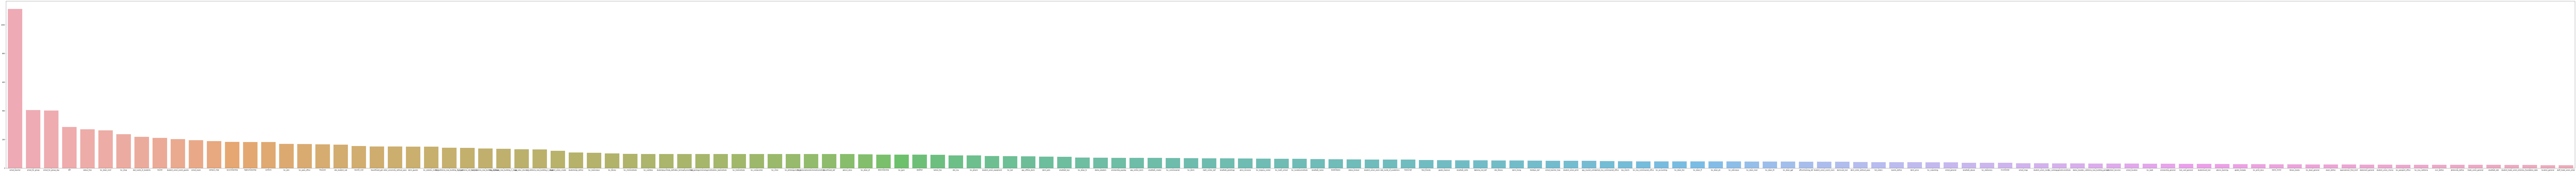

In [ ]:
import seaborn as sns
import matplotlib as plt
from matplotlib.pyplot import figure
cnt_pro = train_data['intent'].value_counts()

figure(figsize=(300,20))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)

In [ ]:
m = list(train_data['intent'].value_counts())
sum(m)/len(m)

93.16901408450704

Так как наименьший класс сильно отличается по размеру с наибольшим, нежелательно использовать метод undersampling. Возможные решения увелечение экземпляров меньших классов за счет дополнения выборки или исскуственное пополнение меньших классов. Также с помощью кластеризации можно объеденить некоторые классы.

In [ ]:
X = train_data.text.values
y = train_data.intent

Преобразование X в вектор с помощью Word2Vec в качестве альтернативного метода векторизации текстов.

In [ ]:
data = []
for text in X:
  data.append(text.split(" "))

In [ ]:
from gensim.models import Word2Vec
import numpy as np

X = train_data.text.values
y = train_data.intent
data = []
for text in X:
  data.append(text.split(" "))
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

w2v_model = Word2Vec(
    min_count=25, window=13, size=100, negative=12)

w2v_model.build_vocab(data)
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=200, report_delay=1)
X = vectorize(X, model=w2v_model)

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)

y = le.transform(y)

# Проявите фантазию и предложите альтернативные методы векторизации, которые дадут лучшее качетсво на классификации
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 4. Обучение классификатора:

## 4.1 Пример обучения классификатора:

In [ ]:
# Обучим Random Forest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=300, random_state=0, n_estimators=50)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=300, n_estimators=50, random_state=0)

In [ ]:
# Сделаем предсказание

prediction = clf.predict(X_test)

In [ ]:
# Оценим качество на отложенных данных
# Начальysq

from sklearn.metrics import f1_score

f1_score(y_test, prediction, average='micro')

0.9191232048374905

## 4.2 Ваш вариант обучения классификатора

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

для альтернативной векторизации нужно подобрать подходящие гипераметры.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 30, 100, 200],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 30, 100, 200],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'auto',
 'n_estimators': 100}

In [ ]:
clf = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=100, criterion = 'entropy', max_features = 'auto')
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, random_state=0)

In [ ]:
prediction = clf.predict(X_test)

In [ ]:

from sklearn.metrics import f1_score

f1_score(y_test, prediction, average='micro')

0.6763224181360201

К сожалению альтернативный метод, сложнее чем мето tf idf и требует более тонкой настройки, он оаказался менее эффективным поэтому попроубем добиться лучших результатов с tfidf

In [ ]:
from sklearn.model_selection import train_test_split

X = train_data.text.values
y = train_data.intent

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_valid = vectorizer.transform(X_valid)

In [ ]:

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_valid = le.transform(y_valid)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [10, 50, 100, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 30, 100, 200],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 30, 100, 200],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 300]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 200,
 'max_features': 'log2',
 'n_estimators': 300}

In [ ]:
# Обучим Random Forest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=200, random_state=0, n_estimators=300, criterion = 'gini', max_features = 'log2')
clf.fit(X_train, y_train)

prediction = clf.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, prediction, average='micro')

0.9231738035264484

In [ ]:
print("Удалось улучшить результаты на ",0.9231 - 0.9191)

Удалось улучшить результаты на  0.0040000000000000036


In [ ]:
from sklearn.metrics import confusion_matrix
c_martix = confusion_matrix(y_test, prediction)

In [ ]:
print("Сумма элементов матрицы ошибок ", c_martix.sum()," из них всего ", c_martix.sum() - sum(list(np.diagonal(c_martix)))," не на диогонали" )

Сумма элементов матрицы ошибок  2382  из них всего  183  не на диогонали


Также попробуем алгоритм наивного Байеса для многомерно распределенных данных, используемый в классификации текста (где данные обычно представляются в виде количества векторов слов, хотя векторы tf-idf также, как известно, хорошо работают на практике).

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'alpha': [0.999, 0.1, 0.101],
    'fit_prior': [True, False]
}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



GridSearchCV(cv=5, estimator=MultinomialNB(alpha=0.1, fit_prior=False),
             param_grid={'alpha': [0.999, 0.1, 0.101],
                         'fit_prior': [True, False]})

In [ ]:
CV_rfc.best_params_

{'alpha': 0.1, 'fit_prior': False}

In [ ]:
clf = MultinomialNB(alpha = 0.001, fit_prior = True )
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.001)

In [ ]:
prediction = clf.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, prediction, average='micro')

0.9156171284634761

In [ ]:
0.9231738035264484 - 0.9156171284634761

0.007556675062972307

Модель случайного леса показывает результаты немного лучше, но модель наивного баеса имеет меньше гиперпараметров и обучается намного быстрее, поэтому будем использовать это решение. А также модель занимает намного меньше памяти, модель случайного леса заняла 836 мб а наивный байес 6.38 мб.

# 5. Деплой классификатора на хостинге Heroku с интерфейсом в Телеграм

На этом шаге мы хотим сделать телеграм бота, который будет классифицировать обращения и возвращать описание интента.

## 5.1 Научимся сохранять обученные модели sklearn

In [ ]:
import _pickle as cPickle

def save_model(model, filename):
    with open(filename, 'wb') as fid:
        cPickle.dump(model, fid)

def load_model(filename):
    with open(filename, 'rb') as fid:
        model = cPickle.load(fid)
    return model

In [ ]:
# Сохраняем:

save_model(clf, './NB_classifier.pkl')
save_model(vectorizer, './vectorizer.pkl')
save_model(le, './le.pkl')

In [ ]:
# Загружаем:

clf = load_model('./classifier.pkl')
vectorizer = load_model('./vectorizer.pkl')
le = load_model('./le.pkl')

In [ ]:
# Делаем предсказание:

my_test_data  = [
                 'расписание ммф',
                 'оформить мат помощь',
                 'где находится мед пункт',
                 'ближайший банкомат'
]

my_test_data = vectorizer.transform(my_test_data)
predict_labels = clf.predict(my_test_data)
le.inverse_transform(predict_labels)

array(['loc_dean_mmf', 'finassist', 'loc_commissariat', 'loc_atm'],
      dtype=object)

In [ ]:
my_test_data = ['расписание ггф']
my_test_data = vectorizer.transform(my_test_data)
predict_labels = clf.predict(my_test_data)
response = le.inverse_transform(predict_labels)
response[0]

'loc_dean_ggf'

## 5.2 Создание Телеграм бота на Python

Бот был создан на основе следующего туториала

https://mastergroosha.github.io/telegram-tutorial/docs/lesson_01/

## 5.3 Деплой приложения на Heroku

Бота задеплоил по следующей инструкции
https://ru.stackoverflow.com/questions/896229/%D0%94%D0%B5%D0%BF%D0%BB%D0%BE%D0%B9-%D0%B1%D0%BE%D1%82%D0%B0-%D0%BD%D0%B0-%D1%81%D0%B5%D1%80%D0%B2%D0%B5%D1%80%D0%B5-heroku?

Имя бота в телеграмм @ShiftChat_bot